In [1]:
import torch
import os
import numpy as np
import cv2
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data

In [3]:
# chuyển đổi nhãn phù hợp với định dạng yolo
def convert_labels_to_yolo_format (boxes, grid_size=7, num_classes=2):
    label = torch.zeros((grid_size, grid_size, 5 * 2 + num_classes))
    
    for box in boxes:
        cls_id, x, y, w, h = box
        cell_x, cell_y = int(x * grid_size), int(y * grid_size) # ô chịu trách nhiệm có tâm đối tượng
        cell_x_frac, cell_y_frac = x * grid_size - cell_x, y * grid_size - cell_y
        label[cell_x, cell_y, :5] = torch.tensor([cell_x_frac, cell_y_frac, w, h, 1.0], dtype=torch.float32)
        label[cell_x, cell_y, 5:10] = torch.tensor([cell_x_frac, cell_y_frac, w, h, 0.0], dtype=torch.float32)
        label[cell_x, cell_y, 10 + int(cls_id)] = 1.0

    return label # (7, 7, 5 * 2 + 2)

# định nghĩa tập dữ liệu phù hợp với yolo
class YoloDataset(Dataset):
    def __init__ (self, img_dir, label_dir, resize):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg'))]
        self.resize = resize

    def __len__ (self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + '.txt')

        # ảnh
        # bgr -> rgb -> resize -> normalize
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.resize)
        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1)) # (h, w, c) -> (c, h, w)
        image = torch.tensor(image, dtype=torch.float32)

        # nhãn
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls_id, x, y, w, h = map(float, line.strip().split()[:5])
                    boxes.append([cls_id, x, y, w, h])
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 5))
        yolo_target = convert_labels_to_yolo_format(boxes)

        return image, yolo_target

In [35]:
train_img_dir = '/kaggle/input/yolofire/train/images'
train_label_dir = '/kaggle/input/yolofire/train/labels'
val_img_dir = '/kaggle/input/yolofire/valid/images'
val_label_dir = '/kaggle/input/yolofire/valid/labels'
test_img_dir = '/kaggle/input/yolofire/test/images'
test_label_dir = '/kaggle/input/yolofire/test/labels'

new_size=224

train_dataset = YoloDataset(
    img_dir=train_img_dir,
    label_dir=train_label_dir,
    resize=(new_size, new_size)
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=4,
    shuffle=True,
    collate_fn=lambda batch: tuple(zip(*batch))
)

val_dataset = YoloDataset(
    img_dir=val_img_dir,
    label_dir=val_label_dir,
    resize=(new_size, new_size)
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=4,
    shuffle=False,
    collate_fn=lambda batch: tuple(zip(*batch))
)

test_dataset = YoloDataset(
    img_dir=test_img_dir,
    label_dir=test_label_dir,
    resize=(new_size, new_size)
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=4,
    shuffle=True,
    collate_fn=lambda batch: tuple(zip(*batch))
)

In [5]:
# kiểm tra Dataloader
images, targets = next(iter(train_loader))
print(f"Số lượng ảnh: {len(images)}")
print(f"Kích thước ảnh: {images[0].shape}")
print(f"Kích thước nhãn: {targets[0].shape}")

Số lượng ảnh: 4
Kích thước ảnh: torch.Size([3, 224, 224])
Kích thước nhãn: torch.Size([7, 7, 12])


cuda:0
cuda:0


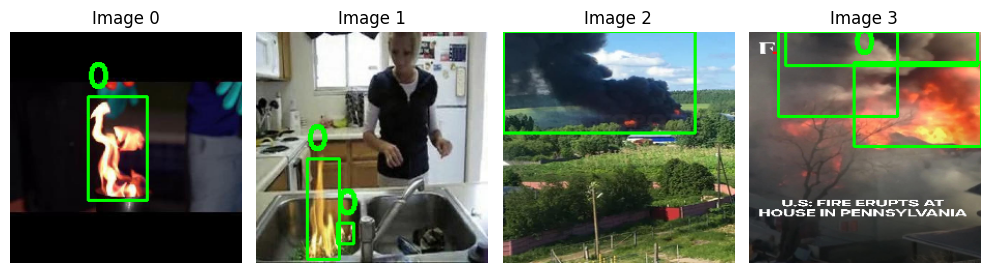

In [21]:
# in ảnh từ Dataloader
images, targets = next(iter(train_loader))
images = [img.to(device) for img in images]
targets = [tgt.to(device) for tgt in targets]
print(images[0].device)
print(targets[0].device)

num_imgs = 4
cols = 4
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(rows * 10, cols * 5))

for i, (image, target) in enumerate(zip(images, targets)):
    image_pil = TF.to_pil_image(image) 
    image_cv = np.array(image_pil)[:,:,::-1].copy()
    H, W = image_cv.shape[:2]
    S = target.shape[0]

    for ix in range(S):
        for iy in range(S):
            cell = target[ix, iy]

            conf = cell[4].item()

            if conf == 0: continue

            x_frac, y_frac, w_frac, h_frac = cell[0:4].tolist()
            cls_id = int(torch.argmax(cell[10:]))

            abs_x = (ix + x_frac) / S
            abs_y = (iy + y_frac) / S

            xmin = int((abs_x - w_frac/2) * W)
            ymin = int((abs_y - h_frac/2) * H)
            xmax = int((abs_x + w_frac/2) * W)
            ymax = int((abs_y + h_frac/2) * H)

            cv2.rectangle(image_cv, (xmin, ymin), (xmax, ymax), (0,255,0), 2)

            label = f"{int(cls_id)}"
            cv2.putText(image_cv, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    ax = axes[i]
    ax.imshow(image_cv[:, :, ::-1])
    ax.axis('off')
    ax.set_title(f"Image {i}")

plt.tight_layout()
plt.show()

## Model

In [7]:
backbone = models.mobilenet_v2(pretrained=True).features # input: (Batch, 224, 224, 3), output: (Batch, 1280, 7, 7)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 116MB/s] 


In [8]:
class YOLOv1(torch.nn.Module):
    def __init__ (self, backbone):
        super().__init__()
        self.backbone = backbone # sequential

        # head
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(1280, 2048, kernel_size=3, padding=1), # mở rộng đặc trưng
            torch.nn.LeakyReLU(0.1),
            torch.nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(0.1)
        )

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1024 * 7 * 7, 2048), # kích thước feature map 7*7
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Linear(2048, 7 * 7 * 12) # lưới 7*7*(2 lớp + 5 tham số * 2 boxes)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, 7, 7, 12)

## Loss function

In [9]:
def compute_iou(box1, box2):
    # box1: Tensor shape (N, 4), N là số lượng ô có object
    # box format: (xc, yc, w, h)
    box1_xy1 = box1[..., :2] - box1[..., 2:] / 2
    box1_xy2 = box1[..., :2] + box1[..., 2:] / 2
    box2_xy1 = box2[..., :2] - box2[..., 2:] / 2
    box2_xy2 = box2[..., :2] + box2[..., 2:] / 2

    # Intersection
    inter_xy1 = torch.max(box1_xy1, box2_xy1)
    inter_xy2 = torch.min(box1_xy2, box2_xy2)
    inter_wh = (inter_xy2 - inter_xy1).clamp(min=0)
    inter_area = inter_wh[..., 0] * inter_wh[..., 1]

    # Area
    box1_area = (box1_xy2[..., 0] - box1_xy1[..., 0]) * (box1_xy2[..., 1] - box1_xy1[..., 1])
    box2_area = (box2_xy2[..., 0] - box2_xy1[..., 0]) * (box2_xy2[..., 1] - box2_xy1[..., 1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / (union_area + 1e-6)


In [10]:
def yolo_loss(preds, targets, lambda_coord=5, lambda_noobj=0.5):
    batch_size = preds.size(0)
    S = 7 # lưới
    B = 2 # anchor boxes mỗi cell

    pred_boxes = preds[..., :10].view(batch_size, S, S, B, 5) # (x, y, w, h, conf) * 2
    target_boxes = targets[..., :10].view(batch_size, S, S, B, 5)
    pred_classes = preds[..., 10:]
    target_classes = targets[..., 10:]

    # đánh dấu ô lưới chứa đối tượng 
    obj_mask = target_boxes[..., 0, 4] > 0
    noobj_mask = ~obj_mask

    # gán trách nhiệm box cho ô chứa đối tượng dự đoán box nào có giá trị iou tốt nhất
    pred_box0 = pred_boxes[..., 0, :5][obj_mask]
    pred_box1 = pred_boxes[..., 1, :5][obj_mask]
    target_box = target_boxes[..., 0, :5][obj_mask]
    iou0 = compute_iou(pred_box0[..., :4], target_box[..., :4])
    iou1 = compute_iou(pred_box1[..., :4], target_box[..., :4])


    responsible_mask = iou0 > iou1

    pred_box = torch.where(
            responsible_mask.unsqueeze(-1),
            pred_box0,
            pred_box1
        )
    
    # 1. localization loss
    coord_loss = 0
    if obj_mask.sum() > 0:
        # sai số tọa độ
        xy_loss = F.mse_loss(pred_box[..., 0:2], target_box[..., 0:2], reduction='sum')

        # sai số kích thước
        pred_wh = torch.sqrt(pred_box[..., 2:4].clamp(min=0))
        target_wh = torch.sqrt(target_box[..., 2:4])
        wh_loss = F.mse_loss(pred_wh, target_wh, reduction='sum').clamp(min=0)

        coord_loss = lambda_coord * (xy_loss + wh_loss)

    # 2. confidence loss
    # box chứa vật thể
    conf_obj_loss = 0
    if obj_mask.sum() > 0:
        pred_conf_obj = pred_box[..., 4]
        target_conf_obj = target_box[..., 4]
        conf_obj_loss = F.mse_loss(pred_conf_obj, target_conf_obj, reduction='sum')

    # box không chứa vật thể (tất cả box) 
    pred_conf_noobj = pred_boxes[..., :, 4][noobj_mask.unsqueeze(-1).expand(-1, -1, -1, B)].view(-1)
    target_conf_noobj = target_boxes[..., :, 4][noobj_mask.unsqueeze(-1).expand(-1, -1, -1, B)].view(-1)
    conf_noobj_loss = lambda_noobj * F.mse_loss(pred_conf_noobj, target_conf_noobj, reduction='sum')

    confidence_loss = conf_obj_loss + conf_noobj_loss

    # 3. class loss
    class_loss = 0
    if obj_mask.sum() > 0:
        pred_class = pred_classes[obj_mask]
        target_class = target_classes[obj_mask]
        class_loss = F.cross_entropy(pred_class, target_class, reduction='sum')

    # tổng loss
    total_loss = coord_loss + confidence_loss + class_loss
    total_loss /= batch_size  # chuẩn hóa theo batch size

    return total_loss

## Train

In [30]:
model = YOLOv1(backbone).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [12]:
# check model
input = torch.randn(1,3,224,224).to(device)
with torch.no_grad():
    output = model(input)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 7, 7, 12])


Epoch 1/30 — Train Loss: 4.6145


Epoch 1/30 — Val Loss:   3.2713
  → New best model (Val Loss: 3.2713), saving checkpoint.


Epoch 2/30 — Train Loss: 2.8873


Epoch 2/30 — Val Loss:   2.6925
  → New best model (Val Loss: 2.6925), saving checkpoint.


Epoch 3/30 — Train Loss: 6.9201


Epoch 3/30 — Val Loss:   3.0189
  → No improvement for 1/5 epochs.


Epoch 4/30 — Train Loss: 2.7397


Epoch 4/30 — Val Loss:   2.6847
  → New best model (Val Loss: 2.6847), saving checkpoint.


Epoch 5/30 — Train Loss: 2.4615


Epoch 5/30 — Val Loss:   2.5524
  → New best model (Val Loss: 2.5524), saving checkpoint.


Epoch 6/30 — Train Loss: 2.2977


Epoch 6/30 — Val Loss:   2.3191
  → New best model (Val Loss: 2.3191), saving checkpoint.


Epoch 7/30 — Train Loss: 2.1832


Epoch 7/30 — Val Loss:   2.2377
  → New best model (Val Loss: 2.2377), saving checkpoint.


Epoch 8/30 — Train Loss: 2.0626


Epoch 8/30 — Val Loss:   2.1475
  → New best model (Val Loss: 2.1475), saving checkpoint.


Epoch 9/30 — Train Loss: 1.8970


Epoch 9/30 — Val Loss:   2.0576
  → New best model (Val Loss: 2.0576), saving checkpoint.


Epoch 10/30 — Train Loss: 2.0225


Epoch 10/30 — Val Loss:   2.1040
  → No improvement for 1/5 epochs.


Epoch 11/30 — Train Loss: 1.7649


Epoch 11/30 — Val Loss:   1.9663
  → New best model (Val Loss: 1.9663), saving checkpoint.


Epoch 12/30 — Train Loss: 2.7879


Epoch 12/30 — Val Loss:   1.9873
  → No improvement for 1/5 epochs.


Epoch 13/30 — Train Loss: 1.8269


Epoch 13/30 — Val Loss:   2.0477
  → No improvement for 2/5 epochs.


Epoch 14/30 — Train Loss: 2.2869


Epoch 14/30 — Val Loss:   1.9568
  → New best model (Val Loss: 1.9568), saving checkpoint.


Epoch 15/30 — Train Loss: 1.6590


Epoch 15/30 — Val Loss:   1.9626
  → No improvement for 1/5 epochs.


Epoch 16/30 — Train Loss: 1.6104


Epoch 16/30 — Val Loss:   2.1253
  → No improvement for 2/5 epochs.


Epoch 17/30 — Train Loss: 1.5575


Epoch 17/30 — Val Loss:   1.9024
  → New best model (Val Loss: 1.9024), saving checkpoint.


Epoch 18/30 — Train Loss: 56.7019


Epoch 18/30 — Val Loss:   2.9227
  → No improvement for 1/5 epochs.


Epoch 19/30 — Train Loss: 3.1184


Epoch 19/30 — Val Loss:   2.2146
  → No improvement for 2/5 epochs.


Epoch 20/30 — Train Loss: 2.1446


Epoch 20/30 — Val Loss:   2.0949
  → No improvement for 3/5 epochs.


Epoch 21/30 — Train Loss: 1.7973


Epoch 21/30 — Val Loss:   2.0280
  → No improvement for 4/5 epochs.


Epoch 22/30 — Train Loss: 23798.6769


Epoch 22/30 — Val Loss:   194.2475
  → No improvement for 5/5 epochs.
Early stopping triggered after 22 epochs.
Training stopped early. Best Val Loss: 1.9024


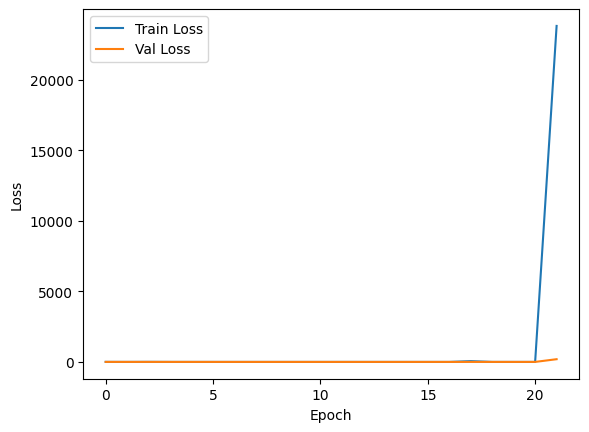

In [23]:
num_epochs = 30
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

epoch_train_losses = []
epoch_val_losses = []

for epoch in range(num_epochs):
    # train
    model.train()
    running_train_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training', leave=False):
        images  = torch.stack([img.to(device) for img in images])
        targets = torch.stack([tgt.to(device) for tgt in targets])

        optimizer.zero_grad()
        outputs = model(images)
        loss = yolo_loss(outputs, targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    epoch_train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_train_loss:.4f}')

    # val 
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} Validation', leave=False):
            images  = torch.stack([img.to(device) for img in images])
            targets = torch.stack([tgt.to(device) for tgt in targets])

            outputs = model(images)
            loss = yolo_loss(outputs, targets)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    epoch_val_losses.append(avg_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs} — Val Loss:   {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_yolo_fire_smoke.pth')
        print(f'  → New best model (Val Loss: {best_val_loss:.4f}), saving checkpoint.')
    else:
        epochs_no_improve += 1
        print(f'  → No improvement for {epochs_no_improve}/{patience} epochs.')

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            early_stop = True
            break

if early_stop:
    print(f'Training stopped early. Best Val Loss: {best_val_loss:.4f}')
else:
    print(f'Training completed. Best Val Loss: {best_val_loss:.4f}')


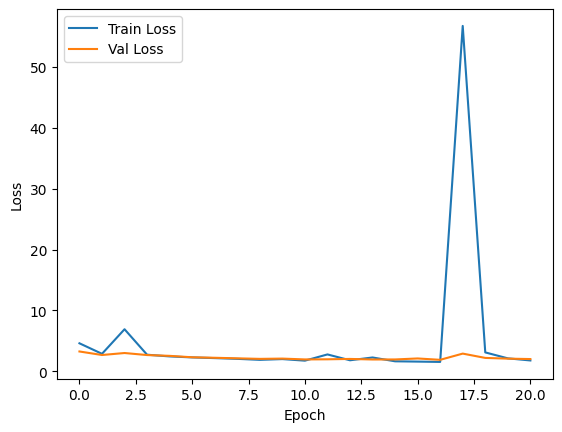

In [24]:
import matplotlib.pyplot as plt
plt.plot(epoch_train_losses[:-1], label='Train Loss')
plt.plot(epoch_val_losses[:-1],   label='Val Loss')
plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.show()

In [31]:
# load model
model.load_state_dict(torch.load('best_yolo_fire_smoke.pth', map_location=device))

<All keys matched successfully>

## Test


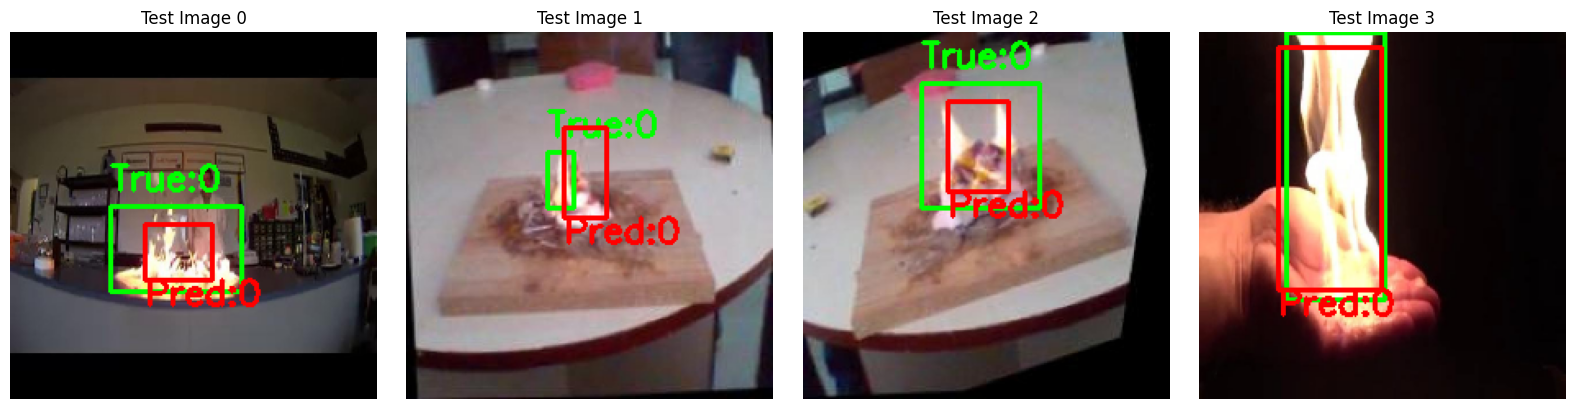

In [44]:
# Lấy một batch từ test_loader
images, targets = next(iter(test_loader))
images = [img.to(device) for img in images]
targets = [tgt.to(device) for tgt in targets]

model.eval()
with torch.no_grad():
    images_tensor = torch.stack(images)
    preds = model(images_tensor)

num_imgs = len(images)
cols = min(num_imgs, 4)
rows = (num_imgs + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

for i, (image, target, pred) in enumerate(zip(images, targets, preds)):
    image_pil = TF.to_pil_image(image)
    image_cv = np.array(image_pil)[:, :, ::-1].copy()
    H, W = image_cv.shape[:2]
    S = target.shape[0] 

    # ground truth
    for ix in range(S):
        for iy in range(S):
            cell = target[ix, iy]
            conf = cell[4].item()
            if conf == 0:
                continue

            x_frac, y_frac, w_frac, h_frac = cell[0:4].tolist()
            cls_id = int(torch.argmax(cell[10:]))

            abs_x = (ix + x_frac) / S
            abs_y = (iy + y_frac) / S

            xmin = int((abs_x - w_frac / 2) * W)
            ymin = int((abs_y - h_frac / 2) * H)
            xmax = int((abs_x + w_frac / 2) * W)
            ymax = int((abs_y + h_frac / 2) * H)

            cv2.rectangle(image_cv, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2) # green
            cv2.putText(image_cv, f"True:{cls_id}", (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # prediction
    for ix in range(S):
        for iy in range(S):
            cell = pred[ix, iy]
            conf = cell[4].item()
            if conf < 0.5:  # chỉ hiển thị các box có độ tin cậy cao
                continue

            x_frac, y_frac, w_frac, h_frac = cell[0:4].tolist()
            cls_id = int(torch.argmax(cell[10:]))

            abs_x = (ix + x_frac) / S
            abs_y = (iy + y_frac) / S

            xmin = int((abs_x - w_frac / 2) * W)
            ymin = int((abs_y - h_frac / 2) * H)
            xmax = int((abs_x + w_frac / 2) * W)
            ymax = int((abs_y + h_frac / 2) * H)

            cv2.rectangle(image_cv, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)  # red
            cv2.putText(image_cv, f"Pred:{cls_id}", (xmin, ymax + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    ax = axes[i] if rows * cols > 1 else axes
    ax.imshow(image_cv[:, :, ::-1])
    ax.axis('off')
    ax.set_title(f"Test Image {i}")

# ẩn subplot thừa
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
